# 数据挖掘互评作业四：离群点分析与异常检测

## 一、实验设定
数据集选择:wine和wave两个数据集。  
任务：使用PCA、SOD和VAE三种无监督离群点检测方法对两个数据集进行离群点检测和分析。  
计算机环境：Ubuntu16.04, 16GB内存，AMD Ryzen R5-3500x。  
评价指标：AUC和PRN(Precision@rank n, 即模型预测时的阈值设为检出离群点比例和GroundTruth中离群点比例相同时的精度,具体见下方代码)。


In [1]:
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score
from pyod.utils.utility import precision_n_scores
def evaluate(clf_name, y, y_pred):
    y = column_or_1d(y)
    y_pred = column_or_1d(y_pred)
    check_consistent_length(y, y_pred)

    return np.round(roc_auc_score(y, y_pred), decimals=4), np.round(precision_n_scores(y, y_pred), decimals=4)

In [2]:
from pyod.models.pca import PCA
from pyod.models.sod import SOD
from pyod.models.xgbod import XGBOD
from pyod.models.vae import VAE

## 二、wine数据集
### 2.1读取数据集&预处理


In [3]:
import os
import csv
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import numpy as np

wine_dir = '/home/linhanxi/homework/wine/benchmarks/'
wine_benches = os.listdir(wine_dir)
print(len(wine_benches))
num_benches = len(wine_benches)
#templ = 'wine_benchmark_{%:d}.csv'

1210


统计各个benchmark的groundtruth离群点比例。

In [72]:
outlier_ratio = []
for i, bench in enumerate(tqdm(wine_benches)):
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    #print('outlier ratio:{:.4f}'.format(np.count_nonzero(labels)/len(labels)))
    #break
    outlier_ratio.append(np.count_nonzero(labels)/len(labels))
    np.save('outlier_ratio.npy', np.array(outlier_ratio))
print(outlier_ratio[:10])

100%|██████████| 1210/1210 [00:16<00:00, 73.24it/s]

[0.010299625468164793, 0.4475671140939597, 0.3559276262489873, 0.36916014042668105, 0.46532156368221944, 0.010075566750629723, 0.10017019207391199, 0.00510752688172043, 0.050051334702258726, 0.001280819724623759]


### 2.2 PCA
主成分分析（PCA）可用于检测异常值。 PCA是线性降维，使用数据的奇异值分解将其投影到较低维的空间。在此过程中，可以将数据的协方差矩阵分解为与特征值关联的正交向量，称为特征向量。 特征值高的特征向量捕获了数据中的大部分方差。因此，由k个特征向量构成的低维超平面可以捕获数据中的大部分方差。 但是，离群值与正常数据点不同，这在特征值较小的特征向量构成的超平面上更为明显。  
因此，可以用样本在所有特征向量上的投影距离之和来检测离群点。
#### 2.2.1 baseline实验

PCA默认设置保留的主成分=总特征向量个数。

In [73]:
auc_PCA = []
prn_PCA = []
for i, bench in enumerate(tqdm(wine_benches)):
    clf_name = 'PCA'
    clf = PCA(n_selected_components=None, whiten=False)
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)
    
    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    #print(auc_, prn_, 'outlier ratio:{:.4f}'.format(np.count_nonzero(labels)/len(labels)))
    #break
    auc_PCA.append(auc_)
    prn_PCA.append(prn_)
    np.save('wine_auc_PCA.npy', np.array(auc_PCA))
    np.save('wine_prn_PCA.npy', np.array(prn_PCA))

100%|██████████| 1210/1210 [00:28<00:00, 42.20it/s]


可以看到PCA算法速度较快，平均每秒就能处理42个benhmark。  
可视化PCA模型的auc指标和prn指标。避免版面过于紧凑起见，仅可视化前100个benchmark。

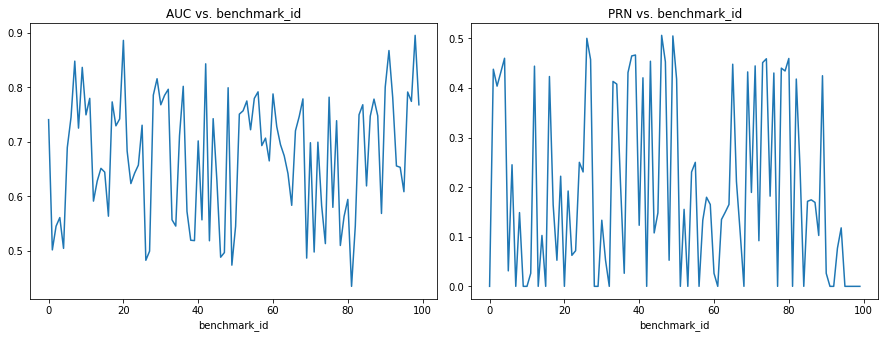

In [135]:
plt.figure(figsize=[12.4,4.8])
plt.subplot(121)
plt.plot(auc_PCA[:100])
plt.xlabel('benchmark_id')
plt.title('AUC vs. benchmark_id')
plt.tight_layout()
plt.subplot(122)
plt.plot(prn_PCA[:100])
plt.xlabel('benchmark_id')
plt.title('PRN vs. benchmark_id')
plt.tight_layout()

发现两个指标在某些benchmark上极低，推测是离群点极少难以正确检测。  
可视化验证:

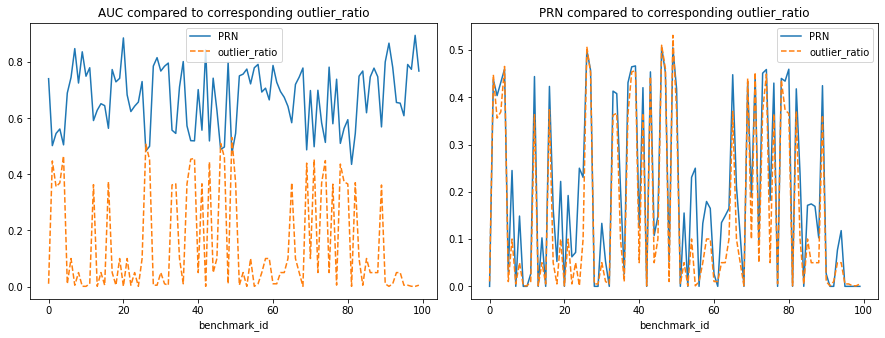

In [132]:
plt.figure(figsize=[12.4,4.8])
plt.subplot(121)
plt.plot(auc_PCA[:100])
plt.plot(outlier_ratio[:100], '--')
plt.xlabel('benchmark_id')
plt.title('AUC compared to corresponding outlier_ratio')
plt.tight_layout()
plt.legend(['PRN', 'outlier_ratio'])
plt.subplot(122)
plt.plot(prn_PCA[:100])
plt.plot(outlier_ratio[:100], '--')
plt.xlabel('benchmark_id')
plt.title('PRN compared to corresponding outlier_ratio')
plt.tight_layout()
plt.legend(['PRN', 'outlier_ratio'])

上图印证了之前的猜想“benchmark中离群点比例与PRN指标呈正相关”。这很好理解，当离群点极少时，样本类别极度不平衡，对算法的精度要求会变的极高。  
而上左图还定性地表示出benchmark中离群点比例与AUC指标呈负相关。

#### 2.2.2PCA模型参数敏感性分析

In [143]:
auc_PCA_10 = []
prn_PCA_10 = []
for i, bench in enumerate(tqdm(wine_benches)):
    clf_name = 'PCA'
    clf = PCA(n_selected_components=10, whiten=False)
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)
    
    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    #print(auc_, prn_, 'outlier ratio:{:.4f}'.format(np.count_nonzero(labels)/len(labels)))
    #break
    auc_PCA_10.append(auc_)
    prn_PCA_10.append(prn_)
    np.save('wine_auc_PCA_10.npy', np.array(auc_PCA))
    np.save('wine_prn_PCA_10.npy', np.array(prn_PCA))

100%|██████████| 1210/1210 [00:28<00:00, 43.03it/s]


In [144]:
auc_PCA_1 = []
prn_PCA_1 = []
for i, bench in enumerate(tqdm(wine_benches)):
    clf_name = 'PCA'
    clf = PCA(n_selected_components=1, whiten=False)
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)
    
    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    #print(auc_, prn_, 'outlier ratio:{:.4f}'.format(np.count_nonzero(labels)/len(labels)))
    #break
    auc_PCA_1.append(auc_)
    prn_PCA_1.append(prn_)
    np.save('wine_auc_PCA_1.npy', np.array(auc_PCA))
    np.save('wine_prn_PCA_1.npy', np.array(prn_PCA))

100%|██████████| 1210/1210 [00:25<00:00, 46.54it/s]


In [146]:
print(np.mean(auc_PCA), np.mean(prn_PCA))
print(np.mean(auc_PCA_10), np.mean(prn_PCA_10))
print(np.mean(auc_PCA_1), np.mean(prn_PCA_1))

0.6861252892561983 0.1720304958677686
0.68580173553719 0.17177768595041323
0.6843050413223141 0.17166826446280992


|保留的特征向量个数|benchmark平均AUC|benchmark平均PRN|
|:----:|----|----|
|all(17)|0.6861252892561983|0.1720304958677686|
|10|0.68580173553719|0.17177768595041323|
|1|0.6843050413223141|0.17166826446280992|
可以看到PCA算法的离群点检测性能对参数保持特征向量个数不敏感（随向量个数的减少性能微小地下降）。


#### 2.2.3  离群点检测降维(tsne)可视化
使用tsne将benchmark1的高维数据降维为2维，并可视化模型预测结果。

In [13]:
def get_label_n(y, y_pred, n=None):

    y_len = len(y)  # the length of targets

    # calculate the percentage of outliers
    if n is not None:
        outliers_fraction = n / y_len
    else:
        outliers_fraction = np.count_nonzero(y) / y_len

    threshold = np.percentile(y_pred, 100 * (1 - outliers_fraction))
    y_pred = (y_pred > threshold).astype('int')

    return y_pred

In [33]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)

def return_result(gt, pred):
    if gt==0 and pred==0:
        return 0
    if gt==0 and pred==1:
        return 1
    if gt==1 and pred==1:
        return 2
    if gt==1 and pred==0:
        return 3
def return_lab(gt, pred):
    if gt==0 and pred==0:
        return 'TN'
    if gt==0 and pred==1:
        return 'FP'
    if gt==1 and pred==1:
        return 'TP'
    if gt==1 and pred==0:
        return 'FN'

which_to_visualzie = 1 
for i, bench in enumerate(tqdm(wine_benches[which_to_visualzie:which_to_visualzie+1])):
    clf_name = 'PCA'
    clf = PCA(n_selected_components=None, whiten=False)
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    
    X_trans = tsne.fit_transform(X_train)
    clf.fit(X_train)
    
    #y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    #auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    y_test_pred = get_label_n(labels, y_test_scores, n=None)
    color = [return_result(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    lab = [return_lab(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    #plt.scatter(X_trans[:, 0], X_trans[:, 1], c=color, cmap=plt.cm.Spectral)



100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


Text(0.5, 1.0, 'TSNE visualization of the model prediction')

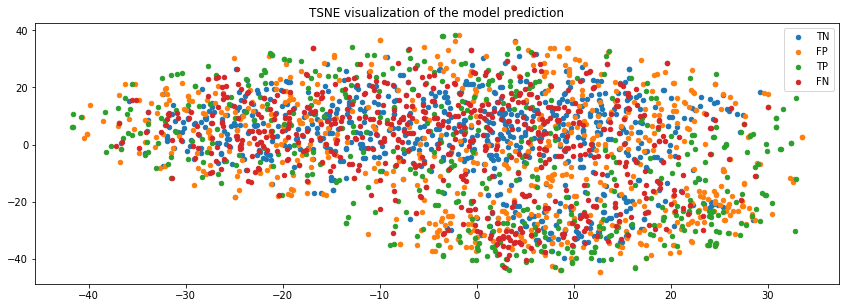

In [34]:
fig, ax = plt.subplots(figsize=[14.4,4.8])
for i in range(4):
    ax.scatter(X_trans[np.array(color)==i, 0], X_trans[np.array(color)==i, 1], s=20,c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i], label=['TN', 'FP', 'TP', 'FN'][i])
ax.legend()
ax.set_title('TSNE visualization of the model prediction')
#plt.legend(['TN', 'FP', 'TP', 'TF'])

离群点设为正样本，普通点设为负样本。即绿色的TP为正确离群点检测。  
注意TSNE可视化只能提供参考，不能完全无损地反映高维空间中的分布情况。在二维空间里出现一些反直觉的实例是正常的。

### 2.3 SOD模型
子空间离群值检测（Subspace outlier detection, SOD）旨在检测高维特征空间的变化子空间中的离群值。 对于每个数据对象，SOD会探索由数据对象的邻居生成(Span)的平行轴子空间，并确定对象在此子空间中相对其邻居的偏离量。
#### 2.3.1 主实验

In [ ]:
auc = []
prn = []
for i, bench in enumerate(tqdm(wine_benches)):
    clf_name = 'SOD'
    clf = SOD()
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)
    
    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    print(auc_, prn_)
    #break
    auc.append(auc_)
    prn.append(prn_)
    np.save('wine_auc.npy', np.array(auc))
    np.save('wine_prn.npy', np.array(prn))

可以看到，SOD的运行算法远比PCA算法慢，每个benchmark平均用时16秒，换算后为每秒1/16=0.0625个benchmark，比PCA算法慢了42/0.0625=672倍。(为不影响观看体验，每个benchmark的输出删去了)

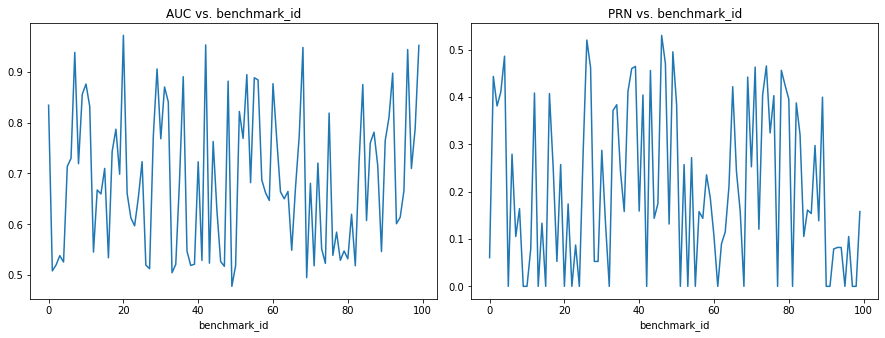

In [238]:
auc = np.load('wine_auc.npy')
prn = np.load('wine_prn.npy')
plt.figure(figsize=[12.4,4.8])
plt.subplot(121)
plt.plot(auc[:100])
plt.xlabel('benchmark_id')
plt.title('AUC vs. benchmark_id')
plt.tight_layout()
plt.subplot(122)
plt.plot(prn[:100])
plt.xlabel('benchmark_id')
plt.title('PRN vs. benchmark_id')
plt.tight_layout()

In [239]:
print(np.mean(auc), np.mean(prn))

0.6984131404958678 0.18519132231404958


|模型|benchmark平均AUC|benchmark平均PRN|速度|
|:----:|----|----|:----:|
|PCA|0.6861252892561983|0.1720304958677686|42benchmark/s|
|SOD|0.6984131404958678|0.18519132231404958|0.0625benchmark/s|
可以看到SOD模型性能比PCA略好，但速度较慢.


因SOD算法速度较慢，故不进行超参数实验

### 2.3.2 TSNE降维可视化预测结果
对benchmark1的tsne降维可视化

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)

def return_result(gt, pred):
    if gt==0 and pred==0:
        return 0
    if gt==0 and pred==1:
        return 1
    if gt==1 and pred==1:
        return 2
    if gt==1 and pred==0:
        return 3
def return_lab(gt, pred):
    if gt==0 and pred==0:
        return 'TN'
    if gt==0 and pred==1:
        return 'FP'
    if gt==1 and pred==1:
        return 'TP'
    if gt==1 and pred==0:
        return 'FN'

which_to_visualzie = 1 
for i, bench in enumerate(tqdm(wine_benches[which_to_visualzie:which_to_visualzie+1])):
    clf_name = 'SOD'
    clf = SOD()
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    
    X_trans = tsne.fit_transform(X_train)
    clf.fit(X_train)
    
    y_test_scores = clf.decision_function(X_train)

    y_test_pred = get_label_n(labels, y_test_scores, n=None)
    color = [return_result(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    lab = [return_lab(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    



100%|██████████| 1/1 [00:13<00:00, 13.43s/it]


Text(0.5, 1.0, 'TSNE visualization of the SOD model prediction')

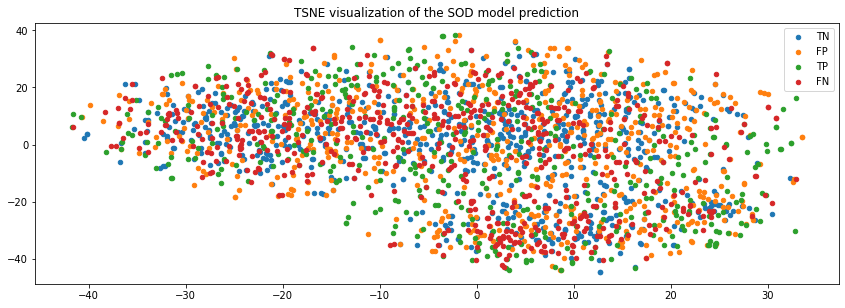

In [32]:
fig2, ax2 = plt.subplots(figsize=[14.4,4.8])
for i in range(4):
    ax2.scatter(X_trans[np.array(color)==i, 0], X_trans[np.array(color)==i, 1], s=20,c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i], label=['TN', 'FP', 'TP', 'FN'][i])
ax2.legend()
ax2.set_title('TSNE visualization of the SOD model prediction')


### 2.4 VAE模型
VAE编码器将数据映射至一个隐空间Z，再将隐空间Z映射回数据来最优化一个重构损失函数，同时隐空间Z还和标准正态分布之间有着KL散度作为损失函数的约束。  
小规模实验发现VAE模型对参数不太敏感，编码器神经元数目和层数设为[8,4,2],解码器为[2,4,8]。

#### 2.4.1 主实验

In [ ]:
from memory_profiler import profile

#@profile
#def dummy():
auc_VAE = []
prn_VAE = []
for i, bench in enumerate(tqdm(wine_benches[66:100])):
    clf_name = 'VAE'
    clf = VAE(encoder_neurons=[8,4,2], decoder_neurons=[2,4,8],verbosity=0)
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)

    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    print(auc_, prn_)
    #break
    auc_VAE.append(auc_)
    prn_VAE.append(prn_)
    np.save('wine_auc_VAE3.npy', np.array(auc_VAE))
    np.save('wine_prn_VAE3.npy', np.array(prn_VAE))
    del clf
    del df
    del X_train
    del labels
#dummy()

为不影响观看体验，每个benchmark的输出删去了

In [16]:
auc_VAE = np.concatenate((np.load('wine_auc_VAE.npy'),np.load('wine_auc_VAE2.npy'),np.load('wine_auc_VAE3.npy')))
prn_VAE = np.concatenate((np.load('wine_prn_VAE.npy'), np.load('wine_prn_VAE2.npy'), np.load('wine_prn_VAE3.npy')))
print(np.mean(auc_VAE), np.mean(prn_VAE))

0.6732920000000001 0.193337


|模型|benchmark平均AUC|benchmark平均PRN|速度|
|:----:|----|:----|:----:|
|PCA|0.6861252892561983|0.1720304958677686|42benchmark/s|
|SOD|0.6984131404958678|0.18519132231404958|0.0625benchmark/s|
|VAE(前100个benchmark)|0.6732920000000001|0.193337|0.04benchmark/s|
因时间有限，只对前100个benchmark训练了VAE模型。

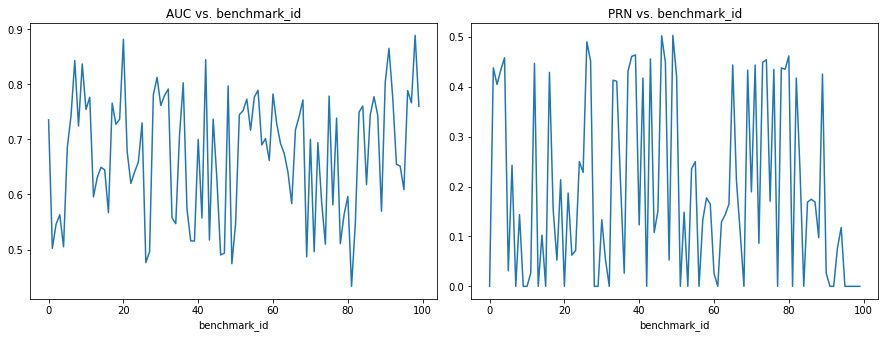

In [14]:
plt.figure(figsize=[12.4,4.8])
plt.subplot(121)
plt.plot(auc_VAE[:100])
plt.xlabel('benchmark_id')
plt.title('AUC vs. benchmark_id')
plt.tight_layout()
plt.subplot(122)
plt.plot(prn_VAE[:100])
plt.xlabel('benchmark_id')
plt.title('PRN vs. benchmark_id')
plt.tight_layout()

### 2.4.2 TSNE降维可视化

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)

def return_result(gt, pred):
    if gt==0 and pred==0:
        return 0
    if gt==0 and pred==1:
        return 1
    if gt==1 and pred==1:
        return 2
    if gt==1 and pred==0:
        return 3
def return_lab(gt, pred):
    if gt==0 and pred==0:
        return 'TN'
    if gt==0 and pred==1:
        return 'FP'
    if gt==1 and pred==1:
        return 'TP'
    if gt==1 and pred==0:
        return 'FN'

which_to_visualzie = 1 
for i, bench in enumerate(tqdm(wine_benches[which_to_visualzie:which_to_visualzie+1])):
    clf_name = 'VAE'
    clf = VAE(encoder_neurons=[8,4,2], decoder_neurons=[2,4,8],verbosity=0)
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    
    X_trans = tsne.fit_transform(X_train)
    clf.fit(X_train)
    
    y_test_scores = clf.decision_function(X_train)

    y_test_pred = get_label_n(labels, y_test_scores, n=None)
    color = [return_result(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    lab = [return_lab(labels[i], y_test_pred[i]) for i in range(len(X_train))]

100%|██████████| 1/1 [00:24<00:00, 24.76s/it]


Text(0.5, 1.0, 'TSNE visualization of the VAE model prediction')

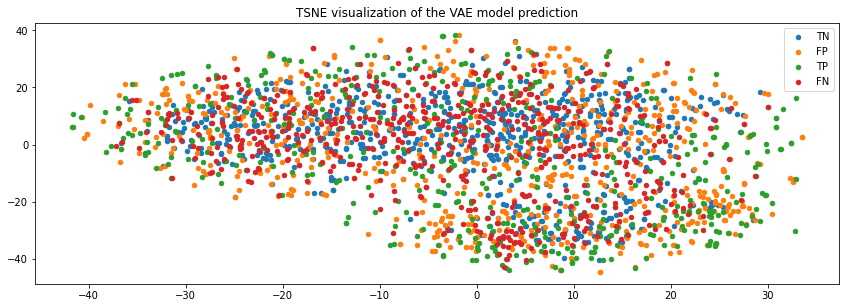

In [30]:
fig3, ax3 = plt.subplots(figsize=[14.4,4.8])
for i in range(4):
    ax3.scatter(X_trans[np.array(color)==i, 0], X_trans[np.array(color)==i, 1], s=20,c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i], label=['TN', 'FP', 'TP', 'FN'][i])
ax3.legend()
ax3.set_title('TSNE visualization of the VAE model prediction')


## 三、wave数据集
### 3.1读取数据集&预处理


In [4]:
import os
wave_dir = '/home/linhanxi/homework/wave/benchmarks/'
wave_benches = os.listdir(wave_dir)
print(len(wave_benches))
num_benches = len(wave_benches)

1080


In [5]:
outlier_ratio = []
for i, bench in enumerate(tqdm(wave_benches)):
    df = pd.read_csv(open(wave_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    #print('outlier ratio:{:.4f}'.format(np.count_nonzero(labels)/len(labels)))
    #break
    outlier_ratio.append(np.count_nonzero(labels)/len(labels))
    np.save('outlier_ratio.npy', np.array(outlier_ratio))
print(outlier_ratio[:10])

100%|██████████| 1080/1080 [00:18<00:00, 59.46it/s]

[0.3252491694352159, 0.01084010840108401, 0.5150375939849624, 0.3325581395348837, 0.10020939276099312, 0.010200723922342876, 0.005494505494505495, 0.01085972850678733, 0.10020939276099312, 0.050205241553520685]


### 3.2 PCA

#### 3.2.1 主实验

In [23]:
auc_PCA2 = []
prn_PCA2 = []
for i, bench in enumerate(tqdm(wave_benches)):
    clf_name = 'PCA'
    clf = PCA(n_selected_components=None, whiten=False)
    df = pd.read_csv(open(wave_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)
    
    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    #print(auc_, prn_, 'outlier ratio:{:.4f}'.format(np.count_nonzero(labels)/len(labels)))
    #break
    auc_PCA2.append(auc_)
    prn_PCA2.append(prn_)
    np.save('wave_auc_PCA2.npy', np.array(auc_PCA2))
    np.save('wave_prn_PCA2.npy', np.array(prn_PCA2))

100%|██████████| 1080/1080 [00:35<00:00, 30.36it/s]


前100个benchmark的AUC和PRN指标可视化

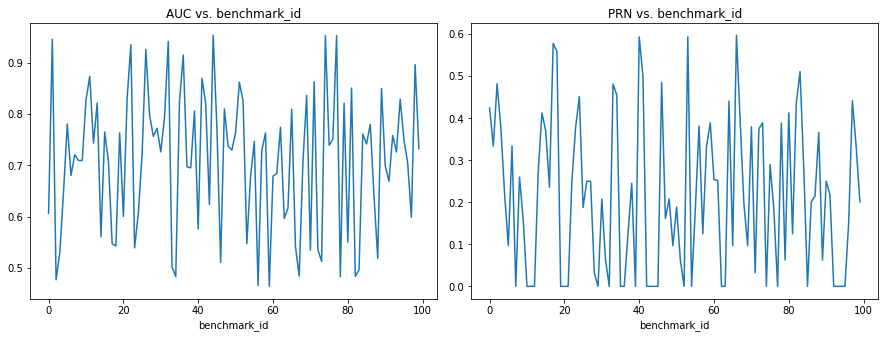

In [24]:
plt.figure(figsize=[12.4,4.8])
plt.subplot(121)
plt.plot(auc_PCA2[:100])
plt.xlabel('benchmark_id')
plt.title('AUC vs. benchmark_id')
plt.tight_layout()
plt.subplot(122)
plt.plot(prn_PCA2[:100])
plt.xlabel('benchmark_id')
plt.title('PRN vs. benchmark_id')
plt.tight_layout()

In [40]:
print(np.mean(auc_PCA2), np.mean(prn_PCA2))

0.7068113888888888 0.21077648148148148


|模型|benchmark平均AUC|benchmark平均PRN|
|:----:|----|----|
|PCA|0.7068113888888888|0.21077648148148148|

#### 3.2.2 TSNE可视化

使用TSNE可视化第2个benchmark的预测结果

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)

def return_result(gt, pred):
    if gt==0 and pred==0:
        return 0
    if gt==0 and pred==1:
        return 1
    if gt==1 and pred==1:
        return 2
    if gt==1 and pred==0:
        return 3
def return_lab(gt, pred):
    if gt==0 and pred==0:
        return 'TN'
    if gt==0 and pred==1:
        return 'FP'
    if gt==1 and pred==1:
        return 'TP'
    if gt==1 and pred==0:
        return 'FN'

which_to_visualzie = 1 
for i, bench in enumerate(tqdm(wave_benches[which_to_visualzie:which_to_visualzie+1])):
    clf_name = 'PCA'
    clf = PCA(n_selected_components=None, whiten=False)
    df = pd.read_csv(open(wave_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    
    X_trans = tsne.fit_transform(X_train)
    clf.fit(X_train)
    
    #y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    #auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    y_test_pred = get_label_n(labels, y_test_scores, n=None)
    color = [return_result(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    lab = [return_lab(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    #plt.scatter(X_trans[:, 0], X_trans[:, 1], c=color, cmap=plt.cm.Spectral)



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Text(0.5, 1.0, 'TSNE visualization of the PCA model prediction')

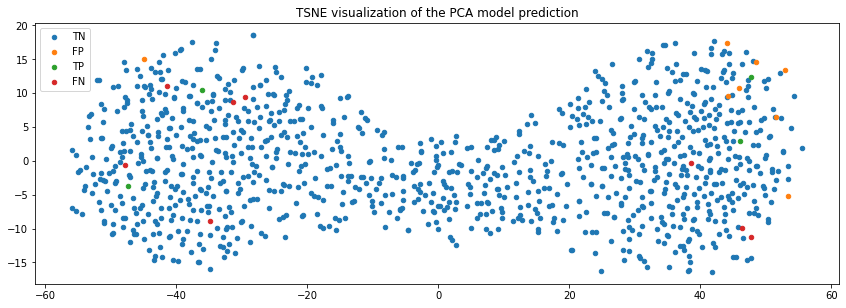

In [27]:
fig4, ax4 = plt.subplots(figsize=[14.4,4.8])
for i in range(4):
    ax4.scatter(X_trans[np.array(color)==i, 0], X_trans[np.array(color)==i, 1], s=20,c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i], label=['TN', 'FP', 'TP', 'FN'][i])
ax4.legend()
ax4.set_title('TSNE visualization of the PCA model prediction')


### 3.3 SOD

#### 3.3.1 主实验

In [ ]:
auc = []
prn = []
for i, bench in enumerate(tqdm(wave_benches)):
    clf_name = 'SOD'
    clf = SOD()
    df = pd.read_csv(open(wave_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)
    
    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    print(auc_, prn_)
    #break
    auc.append(auc_)
    prn.append(prn_)
    np.save('wave_auc.npy', np.array(auc))
    np.save('wave_prn.npy', np.array(prn))

为不影响观看体验，每个benchmark的输出信息删去了

前100个benchmark的AUC和PRN指标可视化

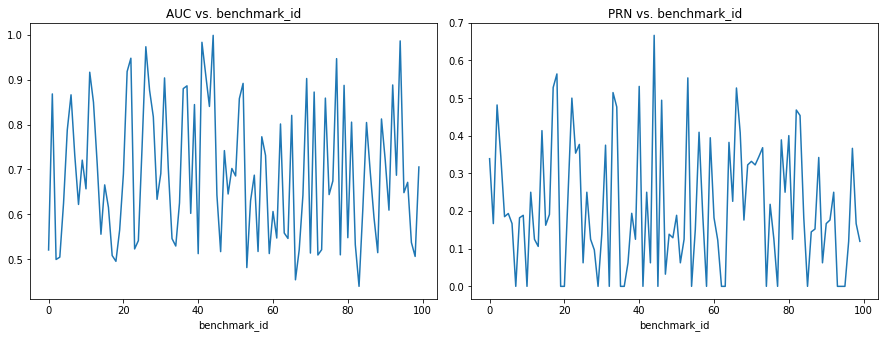

In [38]:
plt.figure(figsize=[12.4,4.8])
plt.subplot(121)
plt.plot(auc[:100])
plt.xlabel('benchmark_id')
plt.title('AUC vs. benchmark_id')
plt.tight_layout()
plt.subplot(122)
plt.plot(prn[:100])
plt.xlabel('benchmark_id')
plt.title('PRN vs. benchmark_id')
plt.tight_layout()

In [39]:
print(np.mean(auc), np.mean(prn))

0.6858422222222221 0.2127173148148148


|模型|benchmark平均AUC|benchmark平均PRN|
|:----:|----|----|
|PCA|0.7068113888888888|0.21077648148148148|
|SOD|0.6858422222222221|0.2127173148148148|
在该数据集里SOD的性能比PCA略差

#### 3.3.2 TSNE可视化

### 使用TSNE可视化第2个benchmark的预测结果

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)

def return_result(gt, pred):
    if gt==0 and pred==0:
        return 0
    if gt==0 and pred==1:
        return 1
    if gt==1 and pred==1:
        return 2
    if gt==1 and pred==0:
        return 3
def return_lab(gt, pred):
    if gt==0 and pred==0:
        return 'TN'
    if gt==0 and pred==1:
        return 'FP'
    if gt==1 and pred==1:
        return 'TP'
    if gt==1 and pred==0:
        return 'FN'

which_to_visualzie = 1 
for i, bench in enumerate(tqdm(wave_benches[which_to_visualzie:which_to_visualzie+1])):
    clf_name = 'SOD'
    clf = SOD()
    df = pd.read_csv(open(wave_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    
    X_trans = tsne.fit_transform(X_train)
    clf.fit(X_train)
    
    #y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    #auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    y_test_pred = get_label_n(labels, y_test_scores, n=None)
    color = [return_result(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    lab = [return_lab(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    #plt.scatter(X_trans[:, 0], X_trans[:, 1], c=color, cmap=plt.cm.Spectral)



100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


Text(0.5, 1.0, 'TSNE visualization of the SOD model prediction')

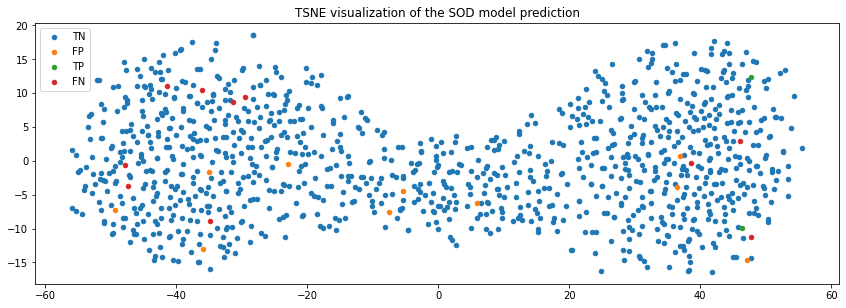

In [22]:
fig5, ax5 = plt.subplots(figsize=[14.4,4.8])
for i in range(4):
    ax5.scatter(X_trans[np.array(color)==i, 0], X_trans[np.array(color)==i, 1], s=20,c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i], label=['TN', 'FP', 'TP', 'FN'][i])
ax5.legend()
ax5.set_title('TSNE visualization of the SOD model prediction')


In [ ]:
from memory_profiler import profile

#@profile
#def dummy():
auc_VAE2 = []
prn_VAE2 = []
for i, bench in enumerate(tqdm(wine_benches[67:100])):
    clf_name = 'VAE'
    clf = VAE(encoder_neurons=[8,4,2], decoder_neurons=[2,4,8],verbosity=0)
    df = pd.read_csv(open(wine_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    clf.fit(X_train)

    y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    print(auc_, prn_)
    #break
    auc_VAE2.append(auc_)
    prn_VAE2.append(prn_)
    np.save('wave_auc_VAE3.npy', np.array(auc_VAE2))
    np.save('wave_prn_VAE3.npy', np.array(prn_VAE2))
    del clf
    del df
    del X_train
    del labels
#dummy()

In [2]:
为不影响观看体验，删去每个benchmark输出信息

SyntaxError: invalid character in identifier (<ipython-input-2-11337de7dddf>, line 1)

In [10]:
auc_VAE = np.concatenate((np.load('wave_auc_VAE.npy'),np.load('wave_auc_VAE2.npy'),np.load('wave_auc_VAE3.npy')))
prn_VAE = np.concatenate((np.load('wave_prn_VAE.npy'), np.load('wave_prn_VAE2.npy'), np.load('wave_prn_VAE3.npy')))
print(np.mean(auc_VAE), np.mean(prn_VAE))

0.6734102040816328 0.19441632653061225


|模型|benchmark平均AUC|benchmark平均PRN|
|:----:|----|----|
|PCA|0.7068113888888888|0.21077648148148148|
|SOD|0.6858422222222221|0.2127173148148148|
|VAE(仅前100个benchmark)|0.6734102040816328|0.19441632653061225|
在wave数据集中PCA由于SOD优于VAE


前100个benchmark的AUC和PRN指标可视化

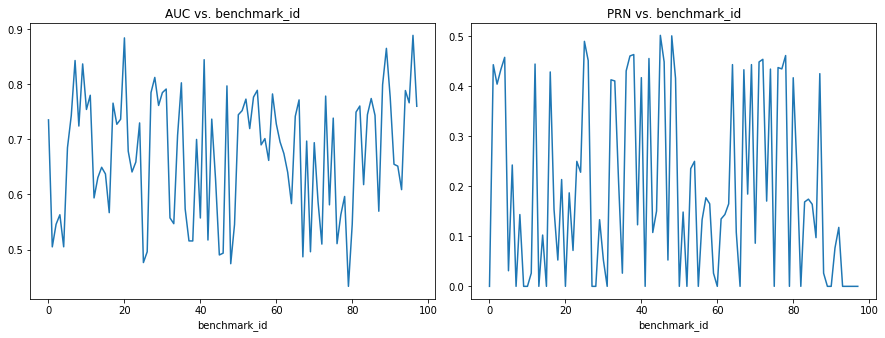

In [11]:
plt.figure(figsize=[12.4,4.8])
plt.subplot(121)
plt.plot(auc_VAE[:100])
plt.xlabel('benchmark_id')
plt.title('AUC vs. benchmark_id')
plt.tight_layout()
plt.subplot(122)
plt.plot(prn_VAE[:100])
plt.xlabel('benchmark_id')
plt.title('PRN vs. benchmark_id')
plt.tight_layout()

#### 3.3.2 TSNE可视化 
### 3.3.3使用TSNE可视化第2个benchmark的预测结果

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)

def return_result(gt, pred):
    if gt==0 and pred==0:
        return 0
    if gt==0 and pred==1:
        return 1
    if gt==1 and pred==1:
        return 2
    if gt==1 and pred==0:
        return 3
def return_lab(gt, pred):
    if gt==0 and pred==0:
        return 'TN'
    if gt==0 and pred==1:
        return 'FP'
    if gt==1 and pred==1:
        return 'TP'
    if gt==1 and pred==0:
        return 'FN'

which_to_visualzie = 1 
for i, bench in enumerate(tqdm(wave_benches[which_to_visualzie:which_to_visualzie+1])):
    clf_name = 'VAE'
    clf = VAE(encoder_neurons=[8,4,2], decoder_neurons=[2,4,8],verbosity=0)
    df = pd.read_csv(open(wave_dir + bench))
    labels = df['ground.truth']
    labels = labels.replace(['anomaly','nominal'], [1,0])
    labels = labels.values
    df.drop(df.columns[[0,1,2,5]], axis=1, inplace=True)
    X_train = df.values
    
    X_trans = tsne.fit_transform(X_train)
    clf.fit(X_train)
    
    #y_test_pred = clf.predict(X_train)
    y_test_scores = clf.decision_function(X_train)

    #evaluate_print(clf_name, labels, y_test_scores)
    #auc_, prn_ = evaluate(clf_name, labels, y_test_scores)
    y_test_pred = get_label_n(labels, y_test_scores, n=None)
    color = [return_result(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    lab = [return_lab(labels[i], y_test_pred[i]) for i in range(len(X_train))]
    #plt.scatter(X_trans[:, 0], X_trans[:, 1], c=color, cmap=plt.cm.Spectral)



100%|██████████| 1/1 [00:11<00:00, 11.62s/it]


Text(0.5, 1.0, 'TSNE visualization of the VAE model prediction')

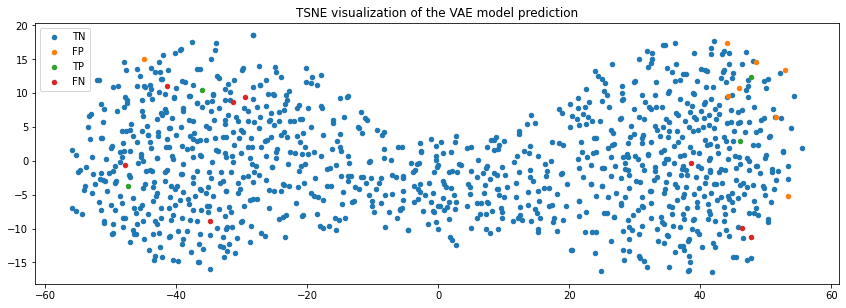

In [20]:
fig6, ax6 = plt.subplots(figsize=[14.4,4.8])
for i in range(4):
    ax6.scatter(X_trans[np.array(color)==i, 0], X_trans[np.array(color)==i, 1], s=20,c=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i], label=['TN', 'FP', 'TP', 'FN'][i])
ax6.legend()
ax6.set_title('TSNE visualization of the VAE model prediction')


## 四、结论
使用PCA、SOD和VAE三种无监督离群点检测方法对两个数据集进行了离群点检测和分析。在这两个数据集上三种模型表现正常，没有发现三种模型的明显性能差异。